# Topics covered

This [notebook](https://nbviewer.jupyter.org/github/btel/python-in-neuroscience-tutorials/blob/master/simulating_conductance_based_neuron.ipynb) is from [Bartosz Teleńczuk](https://datascience.telenczuk.pl/).

**Python**:
  * numpy: using random numbers, reshaping arrays, finding indices, diff, cumsum, searchsorted
  * matplotlib: histogram, plotting spike trains,
  * python: list comprehension, generators,
  * scipy: special and stats modules

**Neuroscience**:
  * different ways of generating of Poisson process,
  * simple spike train statistics: firing rate, Fano factor, CV,
  * Poisson distribution,
  * homogeneous/non-homogeneous Poisson process,

# Introduction

Neurons communicate (mainly) by action potentials also called spikes. Most information about the perceptions, decisions and actions are encoded into the sequence of spikes occuring at specific times. However, when looking at the statistics of spikes recorded from cortical neurons in vivo, the spike occurances are very irregular. Mathematically, such irregular events are described by the Poisson process and Poisson distribution. Below we will simulate Poisson processes imitating the neuronal spikes and introduce several statistics for describing them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

%matplotlib inline

In [32]:
# import quantities as pq  ### todo !!!!!!!

# Poisson process

Imagine that every day on your way to work you count all the red Fiats that you see on the road. We call each such an encounter an event. I think we can safely assume that these events have following properites: 

* events occur randomly with fixed probability,
* events are independent of each other, i.e. the times of the following events do not depend on the time of the previous event.

Poisson process is a random sequence of the number of such events occuring in fixed intervals of time (let's say a number of red Fiats you saw each day). In case of neurons Poisson process could describe a number of spikes registered in fixed time intervals (usually called bins). The simplest way to simulate such a process is to use the Bernoulli approximation in which the bin is chosen small enough that at most only a single event can appear within each of them.

In the implementation we will use `numpy` random number generator. We first generate a sequence of uniformly distributed random numbers (one number per bin) and compare them against the probability of emitting a spike in one bin. The probability is equal to the spike rate (number of events per second) times the bin size. If the random number is below the probability we store "1" to mark an occurrance of a spike. Otherwise, we store 0s. This binary sequence is a binned representation of the train of spikes.

First, we define some constants:

In [62]:
rate = 10 #* pq.Hz    # spike rate
bin_size = 0.001 #* pq.us # bin size 
tmax = 1 #* pq.us      # the total lenght of the spike train

Since we are going to reuse it later, we define the spike train generation algorithm in a seperate function:

In [63]:
def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

**Comments**:

* *Line 2*: we convert the length of the spike train in seconds to bins
* *L4*: generate  uniformly distributed random numbers and compare them to probability of a spike
* *L5*: convert the boolean array to integers and return it

We generate a sample spike train and plot it using standard matplotlib plot function:

10 1 0.001


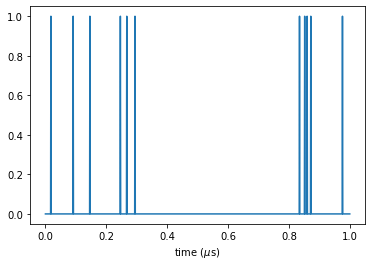

In [97]:
spikes_poisson = homogeneous_poisson(rate, tmax, bin_size)
time = np.arange(len(spikes_poisson)) * bin_size
plt.plot(time, spikes_poisson)
plt.xlabel(r'time ($\mu$s)')
print(rate, tmax, bin_size)

The large spikes in the above plot correspond to, well, spikes. Since this is a random process each realisation will be slightly different. We can generate mulitple realisations or trials in a pythonic way using generators. Generator is like a function but instead of returning a single object (number, array, list, etc.) it can return a sequence of such objects &mdash; one per a time. What differentiates a generator from a function is that it uses `yield` statement instead of `return`:

In [67]:
def homogeneous_poisson_generator(n_trials, rate, tmax, bin_size):
    for i in range(n_trials):
        yield homogeneous_poisson(rate, tmax, bin_size)

To generate 1000 trials we might simply create the generator and pack its results into a list:

In [68]:
spike_trains = list(homogeneous_poisson_generator(1000, rate, tmax, bin_size))

However, this would need enough memory to store all (possible long) spike train. The advatange of generators is that they can be evaluated lazily that is only when the value is really needed. For example, to calculate a number of spikes in each train we can simply sum all ones using a list comprehension:



In [69]:
n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(1000, rate, tmax, bin_size)] 

Note that in this case we do not need to store the spike trains. We simply generate one, calculate the number of spikes, then discard it and generate another train. This can be also done in more functional way using `map` function (which applies the function in its first arguments to all objects returned by the generator):

In [70]:
n_spikes = list(map(np.sum, homogeneous_poisson_generator(1000, rate, tmax, bin_size)))

The functional and list-comprehension approaches are equivalent in terms of performance (and readability), so please go ahead and choose the one you prefer.

Let's look at the distribution of spike counts in the 1000 random realisations of the spike train:

Text(0, 0.5, 'number of realisations')

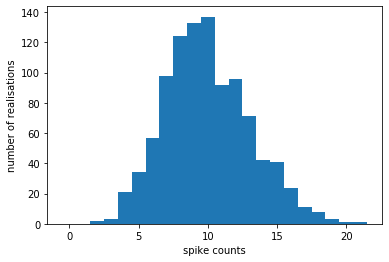

In [75]:
n_spikes = np.array(n_spikes)
bin_edges =  np.arange(n_spikes.max() + 1) - 0.5
plt.hist(n_spikes, bin_edges);
plt.xlabel('spike counts')
plt.ylabel('number of realisations')

This way we obtain a distribution of number of events (spikes) in repeated realisations of a Poisson process with the same rate. Note that the mean and variance of this distribution are both equal to the rate times the spike train length:

In [76]:
print("Mean: {:.1f}".format(n_spikes.mean()))
print("Variance: {:.1f}".format(n_spikes.var()))
print("Rate * train length: {:.1f}".format(rate * tmax))

Mean: 10.0
Variance: 9.6
Rate * train length: 10.0


The ratio of variance to mean is called Fano factor and for Poisson distribution it is equal to 1:

In [77]:
ff = np.var(n_spikes)/np.mean(n_spikes)
print("Fano factor: {:.1f}".format(ff))

Fano factor: 1.0


#Poisson distribution

The Poisson distribution is a probability distribution that describes the number of events occurring at a specific rate in a fixed time interval. We already saw one example of such distribution in the histogram above. This distribution is parameterised by a single parameter $\lambda$ which is simply the product of rate and the length of the time interval. The probability of having $k$ spikes is then given by:

$$P(x=k)=\frac{\lambda^k}{k!}e^{-\lambda}$$

Note that Poisson distribution is a discrete probability distriburion, which means that $k$ can have only integer values. Let's define this distribution in a Python function and then plot it:

In [78]:
def poisson_prob(k, lam):
    return lam**k/special.factorial(k)*np.exp(-lam)

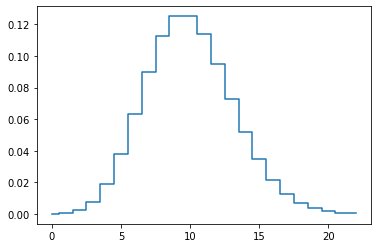

In [79]:
lam = rate * tmax
k = bin_edges + 0.5
prob = poisson_prob(k, lam)
plt.plot(k, prob, drawstyle='steps-mid');

To emphasise that Poisson distribution is discrete I chose to plot it using steps instead the default straight lines. Now we can superimpose the distribution on the histograms we obtained previously.

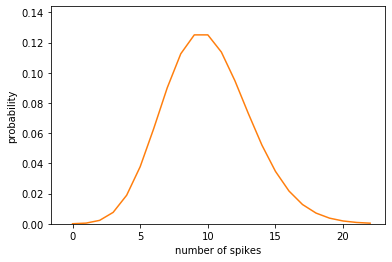

In [86]:
plt.hist(n_spikes, bin_edges, fc='none', density=True)
plt.plot(k, prob)
plt.xlabel('number of spikes')
plt.ylabel('probability')
plt.show()

For reasons of readbility I plotted the distribution in with continous lines instead of steps.

For increasing $\lambda$ the Poisson distribution approaches the Gaussian with mean and variance equal to $\lambda$. Let us plot the distribution for several values of $\lambda$:

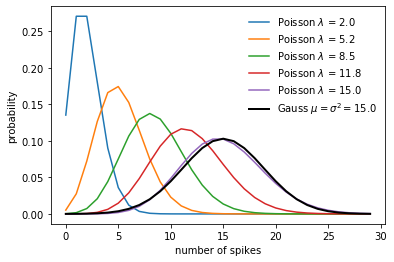

In [87]:
x = np.arange(30)
for lam in np.linspace(2, 15, 5):
    plt.plot(x, poisson_prob(x, lam), label='Poisson $\lambda$ = %.1f' % lam)
def gaussian_pdf(x, mu, sigma_sq):
    return 1/(np.sqrt(2*np.pi*sigma_sq))*np.exp(-(x-mu)**2/sigma_sq/2)
plt.plot(gaussian_pdf(x, lam, lam), 'k', label="Gauss $\mu = \sigma^2=%.1f$" % (lam,), lw=2)
plt.legend(frameon=False)
plt.xlabel('number of spikes')
plt.ylabel('probability');

For comparison I also plotted a Gaussian probability distribution function with variance and mean equal to the largest of $\lambda$s.  We see that the Poisson distribution with this $\lambda$ is well approximated by the Gaussian.

# Sampling from Poisson distribution

Bernoulli approximation works only if  we choose a bin size such that the probability of a spike in each bin is close to 0 and most bins will contain at most one spike. When the bin size is large enough some bins could contain two or more spikes, which could not be captured by the binary Bernoulli distribution.  If we are interested just in the spike counts we could avoid this problem by sampling directly from Poisson distribution. `stats` module from `scipy` package implements random number generators for many different distributions. For example to generate samples from Poisson distribution we can use the `poisson.rvs` (`rvs` stands for random variates) function:

In [88]:
from scipy import stats
lam = 5.
n_spikes = stats.poisson.rvs(lam, size=1000)

This generates 1000 samples from Poisson distribution with $\lambda=5$:

Text(0.5, 0, 'samples')

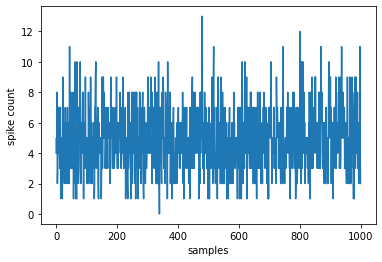

In [89]:
plt.plot(n_spikes);
plt.ylabel('spike count')
plt.xlabel('samples')

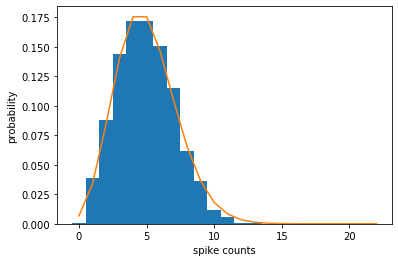

In [92]:
plt.hist(n_spikes, bin_edges, density=True);
plt.plot(k, poisson_prob(k, lam));
plt.xlabel('spike counts')
plt.ylabel('probability');

# Interspike intervals

So far we studied the spike count statistics of the Poisson process. Another way of looking at Poisson process is as a set of time points at which a spike was generated (spike times). We can obtain the spike times from the binned train generated using the Bernoulli approximation by simply finding all 1s in the train. `nonzero` function of `numpy` returns indices of all non-zero elements of the array passed in its argument:

In [94]:
spt,= np.nonzero(spikes_poisson)
print("Indices of first 5 spikes:", spt[:5])

Indices of first 5 spikes: [ 10 116 225 231 288]


To convert the indices into spike times, we just need to multiply them by the bin size. A common way of visualising the spike times is to use **raster plots**.  In a raster plot the time axis is represented in the absisca and each spike is plotted by a single marker, such as a small tick, a point or a star. To generate a raster plot we will use the `vlines` function of matplotlib, which plots vertical lines at the locations specified in its first argument:

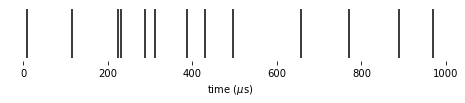

In [98]:
def raster_plot(spt):
    plt.figure(figsize=(8,1))
    plt.subplot(frameon=False)
    plt.vlines(spt, 0, 1)
    plt.xlabel(r'time ($\mu$s)')
    plt.yticks([])
    
raster_plot(spt)

Inter-spike intervals can be calculated using the numpy `diff` function, which calculates differences between consecutive values in the array:

Text(0.5, 0, 'interval index')

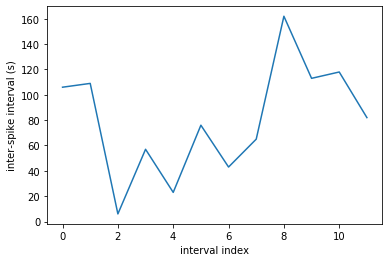

In [99]:
isi = np.diff(spt)
plt.plot(isi)
plt.ylabel("inter-spike interval (s)")
plt.xlabel("interval index")

We will re-use the code later, so let us define a function which calculates inter-spike intervals from the binned spike train:

In [100]:
def calc_isi(binary_train, bin_size):
    spt,= np.nonzero(spikes_poisson)
    spt = spt * bin_size
    isi = np.diff(spt)
    return isi

Now we can plot the histogram of inter-spike intervals:

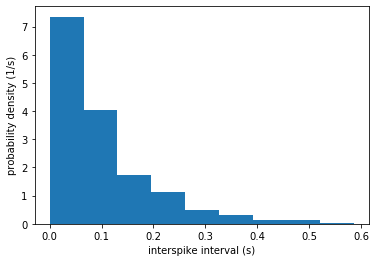

In [103]:
spikes_poisson = homogeneous_poisson(rate, 100 * s, bin_size)
isi = calc_isi(spikes_poisson, bin_size)
isi_bins = np.linspace(0, isi.max(), 10)
plt.hist(isi, isi_bins, density=True)
plt.xlabel("interspike interval (s)")
plt.ylabel("probability density (1/s)");

The inter-spike intervals of Poisson point process are distributed according to exponential distribution. In contrast to the discrete Poisson distribution the exponential distribution is continous probability distribution whose probability density function (pdf) is given by:

$$p(x)=\lambda\exp(-\lambda x)$$

where $\lambda$ parameter is equal to the firing rate.

We can plot superpose the theoretical pdf on the histogram to check their similarity:

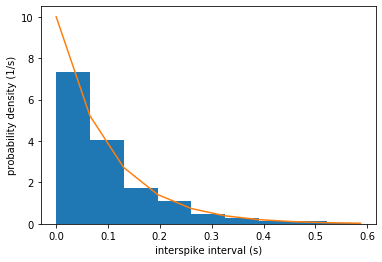

In [104]:
plt.hist(isi, isi_bins, density=True);
def expn_pdf(x, lam):
    return lam*np.exp(-lam*x)
plt.plot(isi_bins, expn_pdf(isi_bins, rate))
plt.xlabel("interspike interval (s)")
plt.ylabel("probability density (1/s)");

The standard deviation and mean of inter-spike intervals of Poisson distribution are equal. Therefore, the ratio between the standard deviation and mean, called [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (CV) is equal to 1. In practice, CV is often used to characterise the "randomness" of a spike train:

In [105]:
cv = np.std(isi)/np.mean(isi) # coefficient of variation
print("Coefficient of variation:", cv)

Coefficient of variation: 0.9618922329487348


We can use the fact that we know the distribution of the inter-spike intervals to generate Poisson spike times. First, we draw random inter-spike intervals from the exponential distribution. To this end, we will use `expon.rvs` function from the `scipy.stats` module:

In [106]:
def generate_isi(rate, n_spikes):
    isi = stats.expon.rvs(scale=1./rate, size=n_spikes)
    return isi

n_spikes = 1000
isi = generate_isi(rate, n_spikes)

Now we just need to sum inter-spike intervals to obtain the spike times. To calculate the cumulative sum of the intervals we can use the `cumsum` function of `numpy`. We test the accuracy of the generated spike train by estimating the spike rate and comparing it against the target rate:

In [107]:
# generation of poisson spikes by means of ISI
spike_train = np.cumsum(isi)
print("Rate: %.1f Hz" % (len(spike_train)/spike_train.max(), ))
print("Target rate: %.1f Hz" % (rate, ))

Rate: 10.0 Hz
Target rate: 10.0 Hz


With this method we obtain directly the spike times, which we can visualize using the raster plot as before:

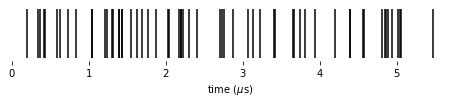

In [108]:
raster_plot(spike_train[:60])

Finally, we may check whether the spike times generated this way really follow the Poisson distribution. To do so we need to bin the spike train that is to count spikes in fixed time intervals. We can define a function which takes the spike times and the bin size as its argument and returns an array of counts:

In [109]:
def count_spikes(spike_train, bin_size):
    bins = np.arange(0, spike_train[-1], bin_size)
    cumulated_counts = np.searchsorted(spike_train, bins)
    counts = np.diff(cumulated_counts)
    return counts

**Comments**:

* **L2**: First, we define an array of bin edges.
* **L3**: We find indices of spikes which follow directly each of the bin edge using the `numpy.searchsorted` function.
* **L4**: The differences of the indices correspond to the number of spikes between the edges. 

# Refractory period

Poisson process is not realistic representation of the spiking statistics in the brain. One biologically implausible property is that the intervals between spikes can be arbitrary short (see the the distribution of the inter-spike intervals above). Real neurons after generating a spike remain unresponsive for some time, called refractory period, during which the ion channels and membrane potential recover to their resting state. We can emulate the refractory period in the Poisson process by adding this period to all generated inter-spike intervals:

In [111]:
rate = 100     # * Hz
refractory_period = 0.008 #* ms

isi = generate_isi(rate, 5000)
isi_ref = isi + refractory_period

Now we can compare the statistics (firing rate tand minimum inter-spike interval) of the Poisson process and the same process with refractory period:

In [112]:
def estimate_rate_from_isi(isi):
    return len(isi)/np.sum(isi)

print("Refractory period:", refractory_period / ms, 'ms')
print("Minimum inter-spike interval:")
print(" - Poisson process: {:.1f} ms".format(isi.min()))
print(" - Poisson with ref. period: {:.1f} ms".format(isi_ref.min() / ms))
print('Firing rate:')
print(" - Poisson process: {:.1f} Hz".format(estimate_rate_from_isi(isi)))
print(" - Poisson with ref. period: {:.1f} Hz".format(estimate_rate_from_isi(isi_ref)))

Refractory period: 0.008 1/ms ms
Minimum inter-spike interval:
 - Poisson process: 0.0 ms
 - Poisson with ref. period: 0.0 ms
Firing rate:
 - Poisson process: 98.6 Hz
 - Poisson with ref. period: 55.1 Hz


Note that by lengthening the inter-spike intervals we also decreased the obtained firing rate. The new firing rate can be calculated from the equation:

$$\nu_\mathrm{ref}=\left(\lambda^{-1}+\tau_{\mathrm{ref}}\right)^{-1}$$

To compensate for the decrease, we need to increase the $\lambda$ parameter of the exponential distribution from which we draw the intervals. If we solve the above equation for $\lambda$ we obtain the correct parameter:

$$\lambda=\left(\nu_\mathrm{ref}^{-1}-\tau_{\mathrm{ref}}\right)^{-1}$$

We now implement this correction in a function generating inter-spike intervals with refractory period:

In [113]:
def generate_isi_refractory(rate, tau_ref, n_spikes):
    lam = 1/(1/rate-tau_ref)
    isi = stats.expon.rvs(scale=1./lam, size=n_spikes)
    isi = isi + tau_ref
    return isi

We can check whether after this modification the expected firing rate and inter-spike intervals are correct:

In [114]:
isi_ref = generate_isi_refractory(rate, refractory_period, 1000)
print("Minimum inter-spike interval: {:.1f} ms".format(isi_ref.min() / ms))
print('Firing rate: {:.1f} Hz'.format(estimate_rate_from_isi(isi_ref)))

Minimum inter-spike interval: 0.0 ms
Firing rate: 100.7 Hz


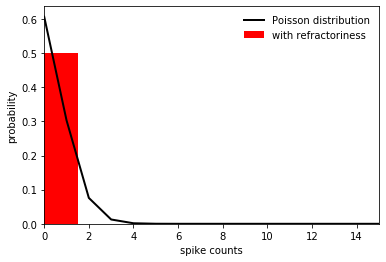

In [117]:
#introducing refractory period
count_interval = 0.0050 # * ms
n_spikes = 5000

isi_ref = generate_isi_refractory(rate, refractory_period, n_spikes)
spike_train_ref = np.cumsum(isi_ref)
counts_ref = count_spikes(spike_train_ref, count_interval)

plt.hist(counts_ref, bin_edges, fc='red', density=True, label='with refractoriness')
plt.plot(k, poisson_prob(k, rate * count_interval), 'k', lw=2, label='Poisson distribution')
plt.xlim(0, 15)
plt.xlabel('spike counts')
plt.ylabel('probability')
plt.legend(frameon=False);

The distribution of the spike counts in a spike train with refractory period (red bars) diverges from the Poisson distribution (black line). This is also reflected in the value of coefficient of variation:

In [118]:
def calc_cv(isi):
    return np.std(isi)/np.mean(isi)
print("CV with refractoriness: {:.1f}".format(calc_cv(isi_ref)))

CV with refractoriness: 0.2


Note that the value is much lower than the CV of the Poisson distribution (equal to 1), which is a sign that a process with refractory period is in fact more regular. This is also directly visible in the raster plot:

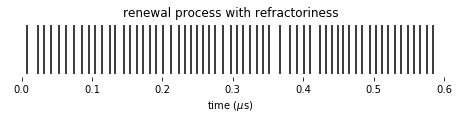

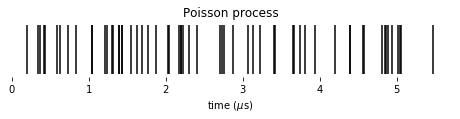

In [119]:
raster_plot(spike_train_ref[:60])
plt.title('renewal process with refractoriness');
raster_plot(spike_train[:60])
plt.title('Poisson process');

# Inhomogeneous Poisson process

So far we only considered homogenous Poisson process that is a process in which the rate is stationary and does not vary in time. However, in nervous system the information about external stimuli is encoded in temporal variations of neuronal activity. In the first approximation, we can consider the case where the firing rate changes, which gives rise to the inhomogeneous Poisson process. To introduce it we simply replace the constant firing rate with an array of firing rates, one value per a bin. For example, we can generate a firing rate oscillating at a frequency of 1 Hz:

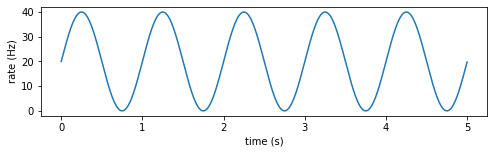

In [120]:
tmax = 5    #*s
max_rate = 40 # * Hz
f_osc = 1 #* Hz
bin_size = 0.002 #* ms
time = np.arange(0, tmax, bin_size)
rate = max_rate * (np.sin(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

To generate the spike trains we can use again the Bernoulli approximation. The only change is that we replace the rate value by an array and compare each random number to consecutive elements of the array. The comparison operators defined in `numpy` work transparently both for single values and arrays, so we do not have to modify the code. We can skip the `tmax` argument of the function (duration of the train), because it can be obtained directly from the length of the rate array. In addition we also define a Python generator to generate multiple trials of the spike train:

In [121]:
def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

We also extend the raster plot to show multiple trials of the spike trains stacked on top of each other. 

In [122]:
def raster_plot_multi(spike_times):
    for i, spt in enumerate(spike_times):
        plt.vlines(spt, i, i+1)
    plt.yticks([])

Let us we simulate 100 trials with the oscillatory rate as shown above and plot them as a raster. 

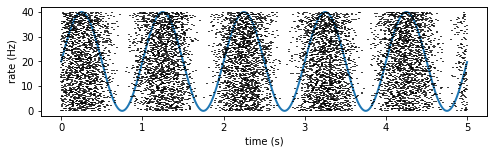

In [123]:
n_trials = 100

plt.figure(figsize=(8,2))
plt.plot(time, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times = list(inhomogeneous_poisson_generator(n_trials, rate, bin_size))
plt.twinx()
raster_plot_multi(spike_times)

From the raster plot you can see how the spikes are modulated in time. The spike density follows the time-dependent rate superimposed on the plot (blue).

Finally, we may calculate the coefficient of variation for one of the trials:

In [124]:
isi = np.diff(spike_times[0])
print("CV – inhomogeneous Poisson: %.1f" % calc_cv(isi))

CV – inhomogeneous Poisson: 2.0


CV of the inhomogeneous Poisson process is higher than 1 indicating that it is more irregular than the homogeneous instance.

To summarize:

* CV = 1 - spike train regularity equal to that of the Poisson process,
* CV < 1 - more regular than the Poisson process (for example due to refractoriness),
* CV > 1 - less regular than the Poisson process (for example due to variations of firing rate or burstiness).